In [1]:
import os
import sys
import pdb
import math
import random
import argparse
import numpy as np
import matplotlib
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from common_performance_stats import collect_txt_files, filter_txt_files, parse_data, ade_fde
from driving_performance_safety import find_collision_rate, find_near_miss_rate, find_ttc
from driving_performance_comfort import find_acceleration_and_jerk
from driving_performance_efficiency import efficiency_time_traveled, average_speed, path_tracking_error, distance_traveled
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

##### Round 1. Priliminary learn the outputs and inspect some

In [56]:
#example_file = '/home/phong/driving_data/official/same_computation/lstmdefault_1Hz/result/joint_pomdp_drive_mode/beijing/pomdp_search_log-0_0_pid-56_r-3712717.txt'
#example_file = '/home/phong/driving_data/test/result/gamma_drive_mode/beijing/pomdp_search_log-0_0_pid-57_r-3737504.txt'
example_file = '/home/phong/driving_data/test/result/gamma_drive_mode/chandni_chowk/pomdp_search_log-0_0_pid-57_r-5300860.txt'

In [57]:
action_list, ego_list, ego_path_list, exos_list, coll_bool_list, \
    pred_car_list, pred_exo_list, trial_list, depth_list, expanded_nodes, total_nodes = parse_data(example_file)

done


Round 2. Official way to plot

In [61]:

def get_prediction_and_driving_performance(ABSOLUTE_DIR):
    #ABSOLUTE_DIR = '/home/phong/driving_data/official/same_computation/lstmdefault_1Hz/'

    prediction_performance = {
        'ade': [],
        'fde': [],
    }

    for root, subdirs, files in os.walk(ABSOLUTE_DIR):
        if len(files) > 0:
            for file in files:
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)
                    print(f"Processing {file_path}")
                    action_list, ego_list, ego_path_list, exos_list, coll_bool_list, \
                        pred_car_list, pred_exo_list, trial_list, depth_list, expanded_nodes, total_nodes = parse_data(file_path)

                    # Prediction performance
                    ego_ade, ego_fde, exo_ade, exo_fde = ade_fde(pred_car_list, pred_exo_list, ego_list, exos_list)
                    prediction_performance['ade'].append(exo_ade)
                    prediction_performance['fde'].append(exo_fde)
                    

    return prediction_performance


# Getting data for same_computation, Need to specify manually the directory
directories_map = {
    'cv_rvo_planner': '/home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode',
    'hivt_rvo_planner': '/home/phong/driving_data/official/gamma_planner/hivt/result/gamma_drive_mode'
}

prediction_performance_map = {}

# Loop through all directories and get the prediction and driving performance
for key, value in directories_map.items():
    print(f"Processing {key}")
    prediction_performance = get_prediction_and_driving_performance(value)
    prediction_performance_map[key] = prediction_performance
    

Processing cv_rvo_planner
Processing /home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-57_r-1965483.txt
done
Processing /home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-57_r-9006489.txt
done
Processing /home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-57_r-5868244.txt
done
Processing /home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-57_r-5037885.txt
done
Processing /home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-57_r-6696004.txt
done
Processing /home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-57_r-6783544.txt
done
Processing /home/phong/driving_data/official/gamma_planner/cv/result/gamma_drive_mode/magic/pomdp_search_log-0_0_pid-56_r-2457961.txt
done
P

In [62]:
print(np.nanmean(prediction_performance_map['cv_rvo_planner']['ade']))

nan


/tmp/ipykernel_3381889/1375847573.py:1: RuntimeWarning: Mean of empty slice
  print(np.nanmean(prediction_performance_map['cv_rvo_planner']['ade']))


In [47]:
#prediction_performance_map['cv_rvo_planner']

In [53]:
print(np.nanmean(prediction_performance_map['hivt_rvo_planner']['ade']))

nan


/tmp/ipykernel_3381889/2839571571.py:1: RuntimeWarning: Mean of empty slice
  print(np.nanmean(prediction_performance_map['hivt_rvo_planner']['ade']))


In [63]:
prediction_performance_map['hivt_rvo_planner']['ade']

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [4]:
def scatter_plot_one_pred_multi_metrics(prediction_performance, driving_performance):  
    # Combine the data into a single DataFrame
    data = {'ADE': prediction_performance['ade']}

    for category, metrics in driving_performance.items():
        for metric, values in metrics.items():
            data[metric] = values

    df = pd.DataFrame(data)

    # Plot the scatter plot matrix
    fig, axes = plt.subplots(3, 4, figsize=(12, 15), sharex=True)

    # Comfort
    axes[0, 0].scatter(df['ADE'], df['jerk'])
    axes[0, 0].set_title('Jerk')

    axes[0, 1].scatter(df['ADE'], df['lateral_acceleration'])
    axes[0, 1].set_title('Lateral Acceleration')

    axes[0, 2].axis('off')
    axes[0, 3].axis('off')

    # Safety
    axes[1, 0].scatter(df['ADE'], df['collision_rate'])
    axes[1, 0].set_title('Collision Rate')

    axes[1, 1].scatter(df['ADE'], df['near_miss_rate'])
    axes[1, 1].set_title('Near Miss Rate')

    axes[1, 2].scatter(df['ADE'], df['mean_min_ttc'])
    axes[1, 2].set_title('Mean Min TTC')

    axes[1, 3].axis('off')


    # Efficiency
    axes[2, 0].scatter(df['ADE'], df['avg_speed'])
    axes[2, 0].set_title('Avg Speed')

    axes[2, 1].scatter(df['ADE'], df['tracking_error'])
    axes[2, 1].set_title('Tracking Error')

    axes[2, 2].scatter(df['ADE'], df['efficiency_time'])
    axes[2, 2].set_title('Efficiency Time')

    axes[2, 3].scatter(df['ADE'], df['distance_traveled'])
    axes[2, 3].set_title('Distance Travelled')

    # Set the x-axis label for all plots
    for ax in axes.flatten():
        ax.set_xlabel('ADE')

    # Add text annotations for each row
    plt.gcf().text(0.02, 0.82, 'Comfort', fontsize=14, fontweight='bold', va='center', rotation='vertical')
    plt.gcf().text(0.02, 0.52, 'Safety', fontsize=14, fontweight='bold', va='center', rotation='vertical')
    plt.gcf().text(0.02, 0.22, 'Efficiency', fontsize=14, fontweight='bold', va='center', rotation='vertical')


    plt.tight_layout()
    plt.show()

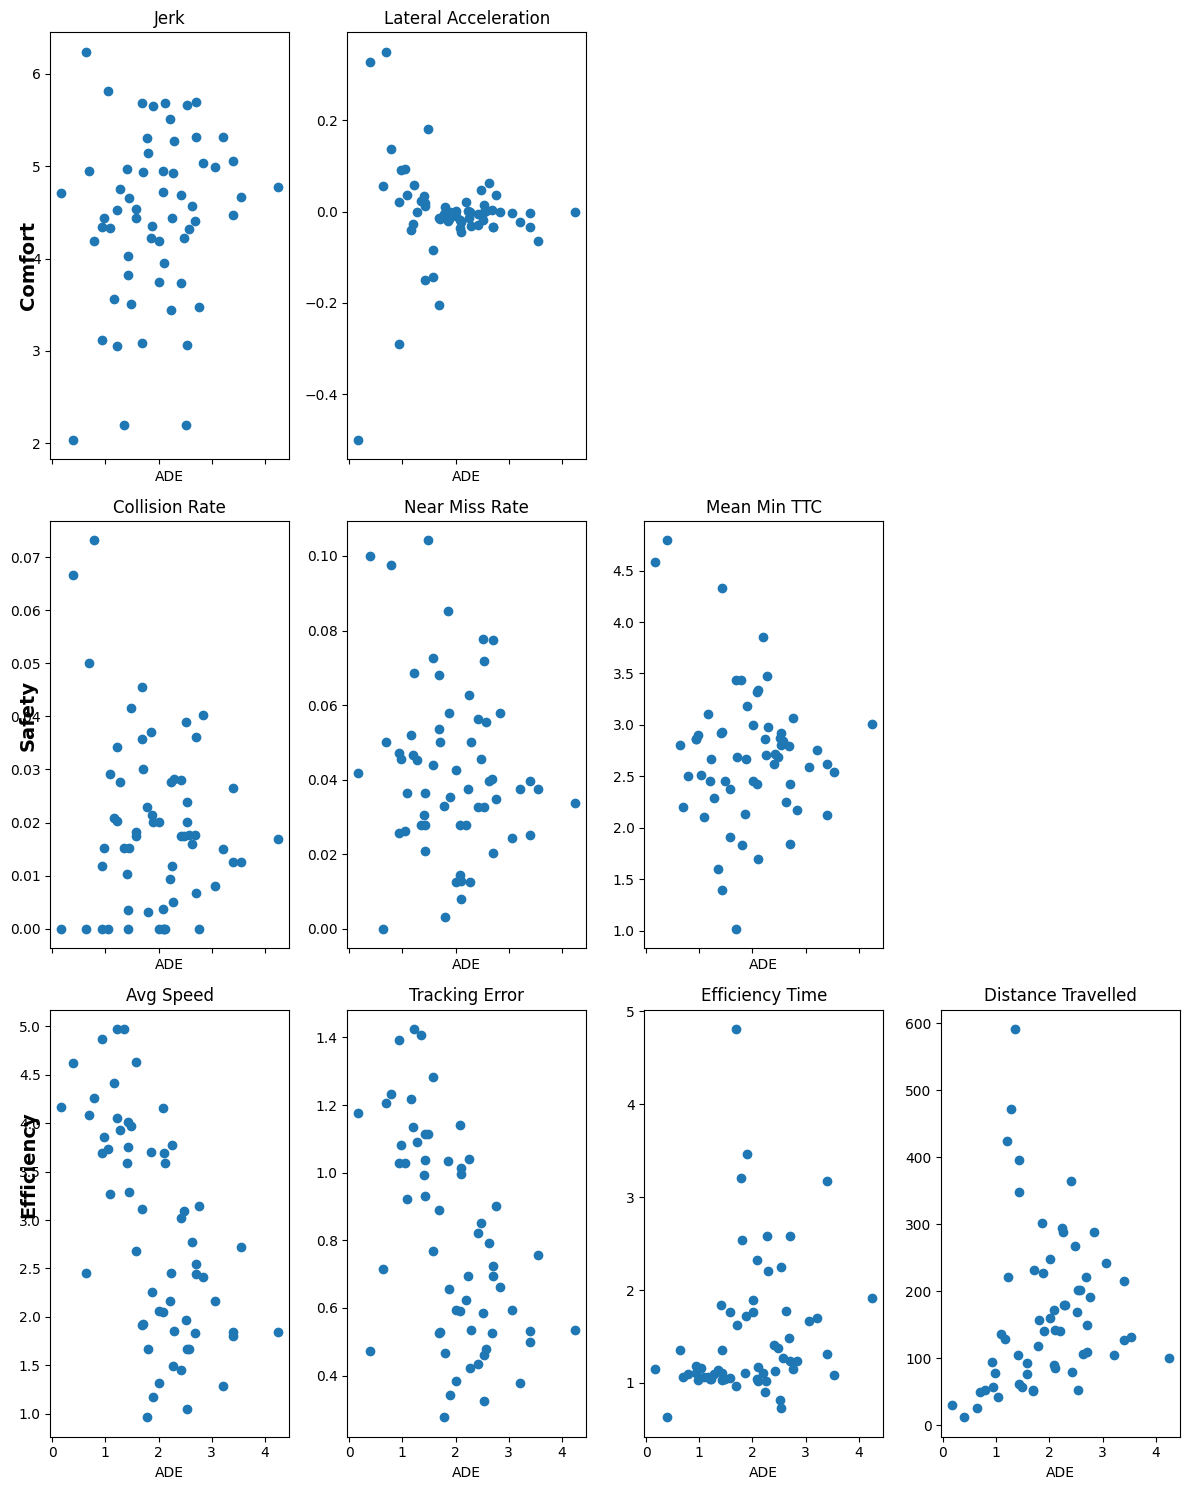

In [5]:
scatter_plot_one_pred_multi_metrics(prediction_performance_map['cv'], driving_performance_map['cv'])

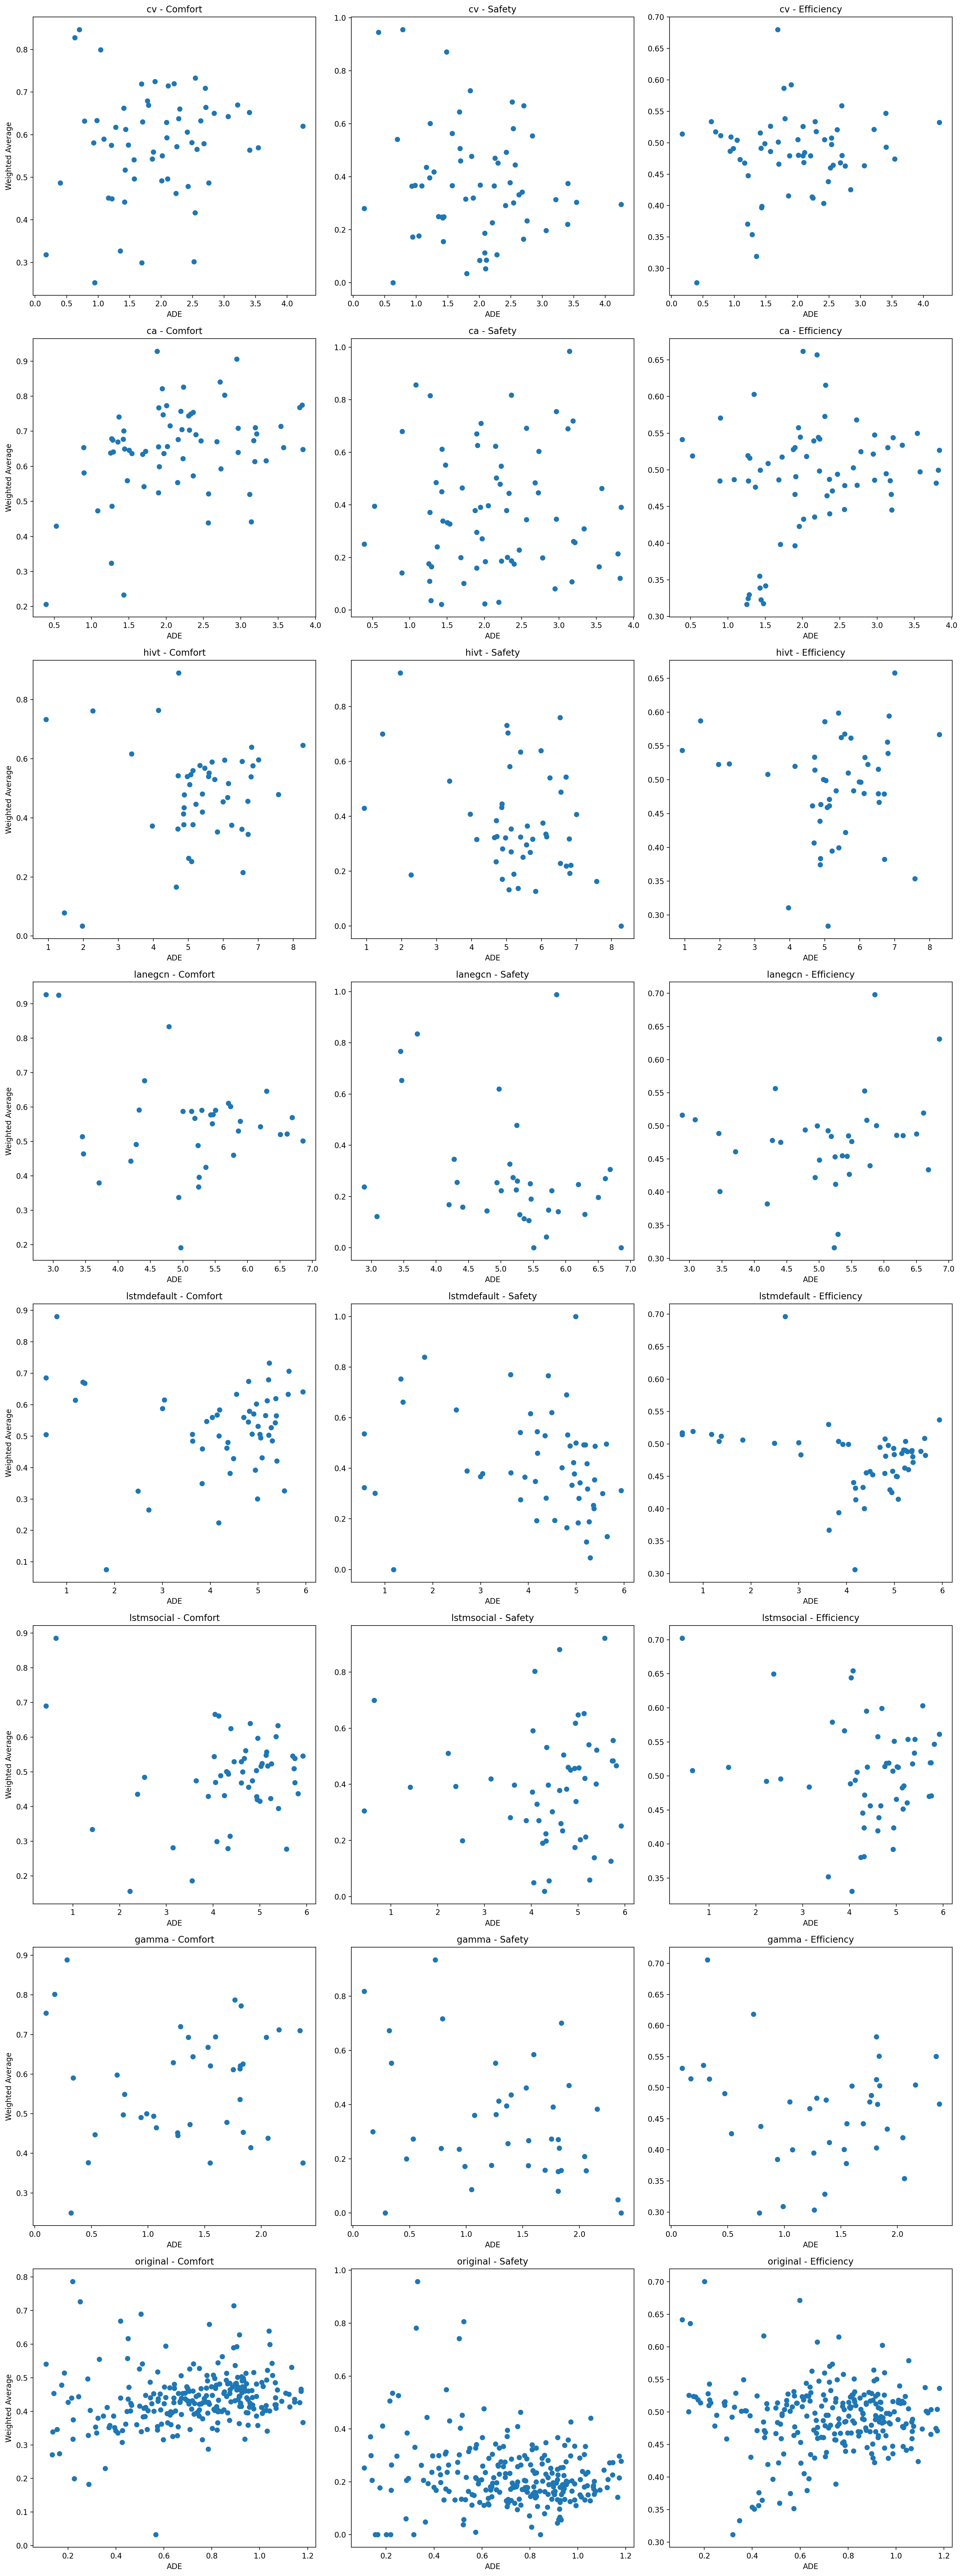

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def scatter_plot_multi_pred_averaged_metrics(prediction_performance, driving_performance, methods_to_plot):  
    # Function to compute the weighted average
    def normalize(arr):
        if np.max(arr) - np.min(arr) == 0:
            return np.zeros_like(arr)
        return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

    def weighted_average(data, weights, directions):
        norm_data = [normalize(arr) if direction == 'lower' else 1 - normalize(arr) for arr, direction in zip(data, directions)]
        return np.sum([w * d for w, d in zip(weights, norm_data)], axis=0)

    def plot_method(method, prediction_performance, driving_performance, row, axes):
        # Weights for each metric within a category
        safety_weights = {
            'collision_rate': 0.3,
            'near_miss_rate': 0.7,
            'mean_min_ttc': 0.0
        }
        safety_directions = {
            'collision_rate': 'lower',
            'near_miss_rate': 'lower',
            'mean_min_ttc': 'higher'
        }
        comfort_weights = {
            'jerk': 0.5,
            'lateral_acceleration': 0.5
        }
        comfort_directions = {
            'jerk': 'lower',
            'lateral_acceleration': 'lower'
        }
        efficiency_weights = {
            'avg_speed': 0.3,
            'tracking_error': 0.3,
            'efficiency_time': 0.2,
            'distance_traveled': 0.2
        }
        efficiency_directions = {
            'avg_speed': 'higher',
            'tracking_error': 'lower',
            'efficiency_time': 'lower',
            'distance_traveled': 'higher'
        }
        

        # Compute the weighted averages for each category
        safety_data = weighted_average(
            [driving_performance[method]['safety']['collision_rate'],
            driving_performance[method]['safety']['near_miss_rate'],
            driving_performance[method]['safety']['mean_min_ttc']],
            list(safety_weights.values()), list(safety_directions.values()))

        comfort_data = weighted_average(
            [driving_performance[method]['comfort']['jerk'],
            driving_performance[method]['comfort']['lateral_acceleration']],
            list(comfort_weights.values()), list(comfort_directions.values()))

        efficiency_data = weighted_average(
            [driving_performance[method]['efficiency']['avg_speed'],
            driving_performance[method]['efficiency']['tracking_error'],
            driving_performance[method]['efficiency']['efficiency_time'],
            driving_performance[method]['efficiency']['distance_traveled']],
            list(efficiency_weights.values()), list(efficiency_directions.values()))

        # Plot the scatter plots
        axes[row, 0].scatter(prediction_performance[method]['ade'], comfort_data)
        axes[row, 0].set_title(f'{method} - Comfort')
        axes[row, 0].set_xlabel('ADE')
        axes[row, 0].set_ylabel('Weighted Average')
        #axes[row, 0].set_xticks(range(len(prediction_performance[method]['ade'])))
        #axes[row, 0].set_xticklabels([f'{val:.2f}' for val in prediction_performance[method]['ade']])


        axes[row, 1].scatter(prediction_performance[method]['ade'], safety_data)
        axes[row, 1].set_title(f'{method} - Safety')
        axes[row, 1].set_xlabel('ADE')

        axes[row, 2].scatter(prediction_performance[method]['ade'], efficiency_data)
        axes[row, 2].set_title(f'{method} - Efficiency')
        axes[row, 2].set_xlabel('ADE')

    # List of methods to plot
    #methods_to_plot = ['method1', 'method2']

    fig, axes = plt.subplots(len(methods_to_plot), 3, figsize=(18, 6 * len(methods_to_plot)))

    for i, method in enumerate(methods_to_plot):
        plot_method(method, prediction_performance, driving_performance, i, axes)

    plt.tight_layout()
    plt.show()

scatter_plot_multi_pred_averaged_metrics(prediction_performance_map, driving_performance_map, ['cv', 'ca', 'hivt', 'lanegcn', 'lstmdefault', 'lstmsocial', 'gamma', 'original'])

In [28]:
for method, val in tree_performance_map.items():
    for key, v in val.items():
        vals = [item for sublist in v for item in sublist]
        print(f"Method {method} - {key}: {np.mean(vals):.2f}")
    


Method ca - expanded_nodes: 70.53
Method ca - total_nodes: 170.14
Method ca - trial: 33.55
Method ca - depth: 6.55
Method cv - expanded_nodes: 113.35
Method cv - total_nodes: 274.28
Method cv - trial: 51.35
Method cv - depth: 7.07
Method hivt - expanded_nodes: 50.66
Method hivt - total_nodes: 126.91
Method hivt - trial: 24.29
Method hivt - depth: 4.72
Method lanegcn - expanded_nodes: 145.00
Method lanegcn - total_nodes: 297.49
Method lanegcn - trial: 72.84
Method lanegcn - depth: 6.52
Method lstmdefault - expanded_nodes: 85.39
Method lstmdefault - total_nodes: 205.86
Method lstmdefault - trial: 40.44
Method lstmdefault - depth: 5.23
Method lstmsocial - expanded_nodes: 147.17
Method lstmsocial - total_nodes: 329.78
Method lstmsocial - trial: 69.04
Method lstmsocial - depth: 6.08
Method gamma - expanded_nodes: 45.67
Method gamma - total_nodes: 113.65
Method gamma - trial: 22.58
Method gamma - depth: 5.71


In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def scatter_plot_multi_pred_3_metric(prediction_performance, driving_performance, methods_to_plot):  
    # Function to compute the weighted average
    def normalize(arr):
        if np.max(arr) - np.min(arr) == 0:
            return np.zeros_like(arr)
        return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

    def weighted_average(data, weights, directions):
        norm_data = [normalize(arr) if direction == 'lower' else 1 - normalize(arr) for arr, direction in zip(data, directions)]
        return np.sum([w * d for w, d in zip(weights, norm_data)], axis=0)

    def plot_method(method, prediction_performance, driving_performance, row, axes):
        # Weights for each metric within a category
        safety_weights = {
            'collision_rate': 0.3,
            'near_miss_rate': 0.5,
            'mean_min_ttc': 0.2
        }
        safety_directions = {
            'collision_rate': 'lower',
            'near_miss_rate': 'lower',
            'mean_min_ttc': 'higher'
        }
        comfort_weights = {
            'jerk': 0.5,
            'lateral_acceleration': 0.5
        }
        comfort_directions = {
            'jerk': 'lower',
            'lateral_acceleration': 'lower'
        }
        efficiency_weights = {
            'avg_speed': 0.3,
            'tracking_error': 0.3,
            'efficiency_time': 0.2,
            'distance_traveled': 0.2
        }
        efficiency_directions = {
            'avg_speed': 'higher',
            'tracking_error': 'lower',
            'efficiency_time': 'lower',
            'distance_traveled': 'higher'
        }

        color = colors[row % len(colors)]

        

        # Compute the weighted averages for each category
        safety_data = weighted_average(
            [driving_performance[method]['safety']['collision_rate'],
            driving_performance[method]['safety']['near_miss_rate'],
            driving_performance[method]['safety']['mean_min_ttc']],
            list(safety_weights.values()), list(safety_directions.values()))

        comfort_data = weighted_average(
            [driving_performance[method]['comfort']['jerk'],
            driving_performance[method]['comfort']['lateral_acceleration']],
            list(comfort_weights.values()), list(comfort_directions.values()))

        efficiency_data = weighted_average(
            [driving_performance[method]['efficiency']['avg_speed'],
            driving_performance[method]['efficiency']['tracking_error'],
            driving_performance[method]['efficiency']['efficiency_time'],
            driving_performance[method]['efficiency']['distance_traveled']],
            list(efficiency_weights.values()), list(efficiency_directions.values()))

         # Add scatter plots for each method
        fig.add_trace(go.Scatter(x=prediction_performance[method]['ade'], y=comfort_data,
                                mode='markers', name=method, marker=dict(color=color)), row=1, col=1)
        fig.add_trace(go.Scatter(x=prediction_performance[method]['ade'], y=safety_data,
                                mode='markers', name=method, marker=dict(color=color), showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=prediction_performance[method]['ade'], y=efficiency_data,
                                mode='markers', name=method, marker=dict(color=color), showlegend=False), row=1, col=3)


    # List of methods to plot
    #methods_to_plot = ['method1', 'method2']

    fig = make_subplots(rows=1, cols=3, subplot_titles=("Comfort", "Safety", "Efficiency"))

    # Define colors for each method
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow'] # Add more colors if needed


    for i, method in enumerate(methods_to_plot):
        plot_method(method, prediction_performance, driving_performance, i, fig)

    # Update axis labels
    fig.update_xaxes(title_text="ADE", row=1, col=1)
    fig.update_yaxes(title_text="Weighted Comfort", row=1, col=1)

    fig.update_xaxes(title_text="ADE", row=1, col=2)
    fig.update_yaxes(title_text="Weighted Safety", row=1, col=2)

    fig.update_xaxes(title_text="ADE", row=1, col=3)
    fig.update_yaxes(title_text="Weighted Efficiency", row=1, col=3)

    # Show the plot
    fig.show()

scatter_plot_multi_pred_3_metric(prediction_performance_map, driving_performance_map, ['cv', 'ca', 'hivt', 'lanegcn', 'lstmdefault', 'lstmsocial'])